# Apache Spark Experiments - Wikipedia Top Contributors

## Spark Application

The application analyses the last revision of every Wikipedia page and outputs the top 10 contributors. Relevant lines:

```python
schema = StructType([
    # ... So Spark doesn't need to scan all the data to infer its schema
])

wikiData = sqlCtx.jsonFile("hdfs://namenode:8020/enwiki.json",
                           schema=schema)
wikiData.registerAsTable("wikiData")
users = sqlCtx.sql("SELECT revision.contributor.username as user, "
                   "       COUNT(*) AS contribs "
                   "FROM wikiData "
                   "WHERE revision.contributor.username <> '' "
                   "GROUP BY revision.contributor.username "
                   "ORDER BY contribs DESC LIMIT 10").collect()

for user in users:
    print("%s: %d" % user)
```

Output for all the Wikipedia dump from enwiki-20150304-pages-articles.xml.bz2 (45 GB of JSON input):

    Addbot: 426703
    RjwilmsiBot: 408537
    Xqbot: 368493
    RussBot: 274009
    Legobot: 267074
    BOTijo: 245795
    AvicBot: 229107
    Cydebot: 224454
    Yobot: 221754
    EmausBot: 177984

## Weak-scaling Experiment

The amount of data is fixed: 1 GB per node, less than the available memory. The nodes are virtual machines from Nuvem USP.

In [1]:
# Show graph in this notebook instead of opening a window
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

# Make graphs more readable
matplotlib.rcParams.update({'font.size': 16, 'font.family': 'serif'})

In [2]:
# Parse and sort Spark applications' log by execution start time
from sparklogstats import LogParser
parser = LogParser()

import glob
apps = []
for log in glob.glob('weak_scaling_data/app-*'):
    parser.parse_file(log)
    app = parser.app
    app.start /= 1000  # msec to sec
    app.end /= 1000
    apps.append(parser.app)
apps.sort(key=lambda x: x.start)
apps = tuple(apps)  # immutable to prevent mistakes

### Scatter Plot
Scatter plot with all durations in *y* and start time in *x*. Uses different colors for each worker amount.

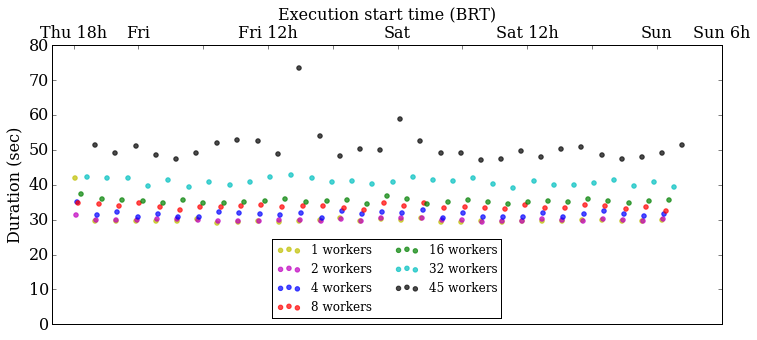

In [3]:
# Moving x axis to the top
_, ax = plt.subplots(figsize=(12,5))
ax.xaxis.set_label_position('top')
ax.xaxis.tick_top()

worker_amounts = tuple(sorted(set((len(app.workers) for app in apps))))
colors = ('y', 'm', 'b', 'r', 'g', 'c', 'k')
min_tstamp = apps[0].start
for worker_amount, color in zip(worker_amounts, colors):
    w_apps = [app for app in apps if len(app.workers) == worker_amount]
    xs = [app.start for app in w_apps]
    ys = [app.duration for app in w_apps]
    label = '{:d} workers'.format(worker_amount)
    plt.scatter(xs, ys, color=color, alpha=0.7, label=label)

plt.legend(loc='lower center', ncol=2, fontsize=12)
plt.ylim(0, 80)
plt.ylabel('Duration (sec)')

# Date and time in x axis
plt.xlabel('Execution start time (BRT)')
h6 = 6 * 60 * 60  # 6 hours in seconds
tstamps = range(1431637200, 1431658800 + 9*h6 + 1, h6)
ts_labels = ['Thu 18h', 'Fri', '', 'Fri 12h', '', 'Sat', '', 'Sat 12h', '', 'Sun', 'Sun 6h']
plt.xticks(tstamps, ts_labels)
plt.xlim(1431637200 - 2 * 3600, 1431658800 + 9*h6)

plt.show()

### Execution Time Prediction

Is it possible to predict the execution time of the whole application (45 GB of data and 45 VMs) using only a few machines?

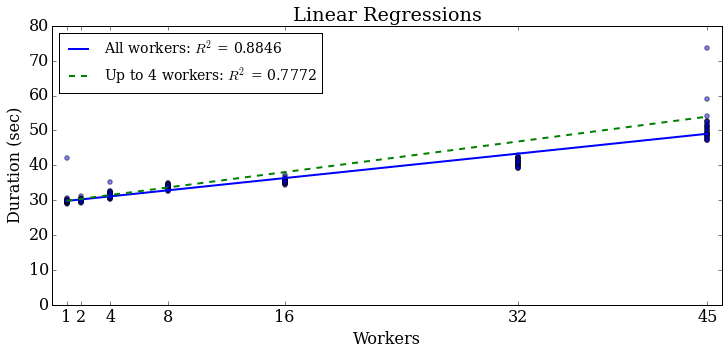

In [4]:
# Linear regression on amount of workers and execution time
plt.subplots(figsize=(12,5))

xs = [len(app.workers) for app in apps]
ys = [app.duration for app in apps]
plt.scatter(xs, ys, alpha=0.5)

# coefficient of determination calculation as in Jain's book,
y_mean = sum(ys)/len(ys)
sst = sum(map(lambda y: (y - y_mean)**2, ys))
def calc_r2(slope, intercept):
    sse = 0
    for app in apps:
        x = len(app.workers)
        y = app.duration
        y_ = intercept + slope*x
        sse += (y - y_)**2
    return (sst - sse)/sst
    
from scipy import stats
def plot_linregress(selected_workers, label, marker):
    _apps = [app for app in apps if len(app.workers) in selected_workers]
    _xs = [len(app.workers) for app in _apps]
    _ys = [app.duration for app in _apps]
    slope, intercept, r_value, p_value, std_err = stats.linregress(_xs, _ys)
    r2 = calc_r2(slope, intercept)
    label += r': $R^{2}$' + ' = {:.4f}'.format(r2)
    def f(x): return intercept + slope*x
    plt.plot([1, 45], [f(1), f(45)], marker, label=label, linewidth=2)

# Linear regressions using different amount of workers
plot_linregress(worker_amounts, label='All workers', marker='-')
plot_linregress((1, 2, 4), label='Up to 4 workers', marker='--')
plt.legend(loc='upper left', fontsize=14)

plt.xlim(0, 46)
plt.xticks(worker_amounts)
plt.ylim(0, 80)
plt.xlabel('Workers')
plt.ylabel('Duration (sec)')
plt.title('Linear Regressions')
plt.show()

In the figure above, we can notice that the experiments with up to 4 workers result in a regression with an $R^{2}$ coeffcient close to the one obtained with all the experiments. Thus, we can have a reasonable prediction by using 10x less VMs.

### Cloud Performance Variability

Is there a correlation between the performance of two consecutive experiments?

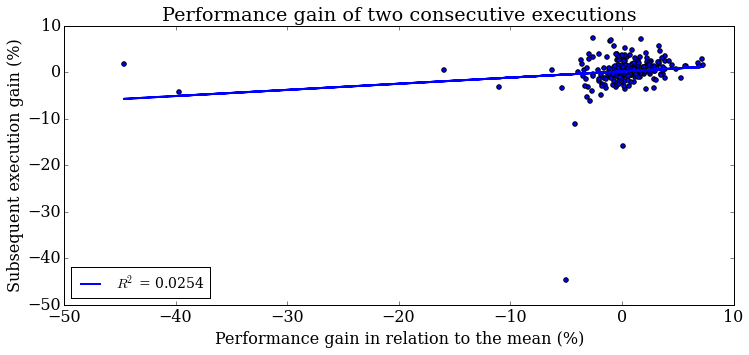

In [5]:
import numpy as np

plt.subplots(figsize=(12,5))

# Duration means by worker amount
means = {}
for w in worker_amounts:
    means[w] = np.mean([a.duration for a in apps if len(a.workers) == w])
    
# Percentage of performance gain in relation to the mean
def calc_perf_gain(app):
    worker_amount = len(app.workers)
    mean = means[worker_amount]
    return (mean - app.duration)/mean * 100

gains = [calc_perf_gain(app) for app in apps]
xs = gains[:-1]
ys = gains[1:]  # ys[i] is the execution that follows xs[i]
plt.scatter(xs, ys)

# Linear regression
slope, intercept, r_value, p_value, std_err = stats.linregress(xs, ys)
def f(x): return intercept + slope*x
label = r'$R^{2}$' + ' = {:.4f}'.format(r_value**2)
plt.plot(xs, list(map(f, xs)), linewidth=2, label=label )

plt.xlabel('Performance gain in relation to the mean (%)')
plt.ylabel('Subsequent execution gain (%)')
plt.title('Performance gain of two consecutive executions')
plt.legend(loc='lower left', fontsize=14)
plt.show()

No correlation has been observed. However, several papers detail the performance variability of Amazon EC2. Running a benchmark right before the application execution may improve the prediction (more experiments should be done)

## Next Steps
* Strong scaling experiments
 * Nuvem USP
 * Amazon EC2
* Predict the minimum amount of VMs given an application deadline
* Analyze other types of applications
* Find common behaviors to improve the model